# Assignment 3 Question2 
### Implemented by:
1. Sushant Kotwal (skotwal)
2. Tejasram Ramesh (terame)
3. Atharva Pandit (atpand)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as functional
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset


import pandas as pd
import matplotlib.pyplot as plt
from model import Model
import numpy as np


In [ ]:
batch_size = 32
train_set = datasets.MNIST(root='MNIST_data/', train = True, transform = transforms.ToTensor(), download = True)
#train_loader = DataLoader(dataset = train_set, batch_size= batch_size, shuffle = True)


#Creating validation set and training sets


index = list(range(len(train_set)))

#Train Set has size 60000, so we create validation set of size 10%
#print(index)
np.random.shuffle(index)
#print(index)
train_split = int(np.floor(0.9*60000))
#print(train_split)

training_set = Subset(train_set,index[:train_split])
validation_set = Subset(train_set,index[train_split:])
#print(len(training_set))
#print(len(validation_set))

training_loader = DataLoader(dataset=training_set,batch_size=batch_size,shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size,shuffle=True)


# Creating test set
test_set = datasets.MNIST(root='MNIST_data/', train = False, transform = transforms.ToTensor(), download = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)



In [ ]:
print("The size of training set is :",len(training_set))
print("The size of validation set is :",len(validation_set))
print("The size of testing set is :",len(test_set))

The size of training set is : 54000
The size of validation set is : 6000
The size of testing set is : 10000


torch.Size([32, 1, 28, 28])


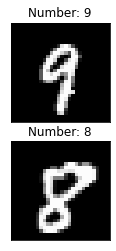

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
print(images.shape)

fig = plt.figure()
for i in range(2):
  plt.subplot(2,1,i+1)
  plt.imshow(images[i].numpy().squeeze(), cmap='gray', interpolation='none')
  plt.title("Number: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net,self).__init__()
        self.layers1 = nn.Sequential(
        nn.Conv2d(1,12,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(12,24,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2)
      )
        self.layers2 = nn.Sequential(
          nn.Linear(in_features=24*7*7,out_features=30),
          nn.ReLU(),
          nn.Linear(in_features=30, out_features=10),
      )
    
    def forward(self,x):
        x=self.layers1(x)
        x=x.view(x.size(0),-1)
        x=self.layers2(x)
        return x


# Xavier-Glorot initialization of weights  
def glorot_weights(m):
    if isinstance(m,nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)


For the CNN architecture, we used the following formula to calculate output size after each layer:

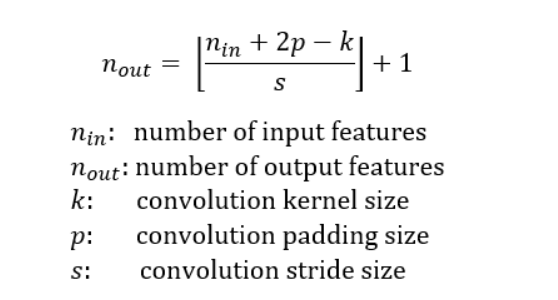

Our input size of image is 28x28 i.e 28, so output after first layer is 28. Then after second layer, the output is 14 and the output after the last pooling layer is 7. The output channel we specify is 24. So the input features for linear layer is 24*7*7 and since the number of classes to identify is 10 the output for last layer is 10

In [ ]:
model = CNN_Net()
model.apply(glorot_weights)
loss_func = nn.CrossEntropyLoss()

optimizer = optim.SGD(momentum=0.9,lr=0.05,params=model.parameters())

lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer , step_size=10, gamma=0.1)

#if (torch.cuda.is_available()):
    #model.cuda()

In [ ]:
print("Training the CNN Model :")
number_of_epochs = 50
#train_loss = list()
best_epoch = None
batch_accuracy =[]


batch_validation_accuracy = []
previous_loss = 100
patience_factor = 4

avg_training_loss = []
avg_training_accuracy = []

avg_validation_loss = []
avg_validation_accuracy = []
count = 0
print("Generating a list of Training and Validation accuracies with their losses :")
for epoch in range(number_of_epochs):
    training_loss = 0
    validation_loss = 0
    model.train()
    
    for i, (x, y) in enumerate(training_loader):
        images = Variable(x)
        labels = Variable(y)
        
        optimizer.zero_grad()
        
        output = model(images)
        
        loss = loss_func(output, labels)
        
        training_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        training_prediction = (torch.max(output.data, dim=1)[1] == labels.data)
        
        batch_accuracy.append(training_prediction.float().mean().item())
    avg_training_accuracy.append(np.mean(batch_accuracy))
    avg_training_loss.append(training_loss/(i+1))
    
    model.eval()
    
    for i, (x, y) in enumerate(validation_loader):
        images2 = Variable(x)
        labels2 = Variable(y)
        
        output2 = model(images2)
        
        loss2 = loss_func(output2, labels2)
        
        validation_loss += loss2.item()
        
        validation_prediction = (torch.max(output2.data, dim=1)[1] == labels2.data)
        
        batch_validation_accuracy.append(validation_prediction.float().mean().item())
    
    avg_validation_accuracy.append(np.mean(batch_validation_accuracy))

        
        
        
    current_validation_loss = validation_loss/(i+1)
    avg_validation_loss.append(current_validation_loss)
    
    
    
    if current_validation_loss < previous_loss:
        count=0
        previous_loss = current_validation_loss
        best_epoch = epoch
        torch.save(model.state_dict(), "model.dth")
        
    else:
        count+=1
        if count==1:
            best_epoch = epoch
        if count>=patience_factor:
            print("Losses for validation data increase from epoch :",best_epoch)
            print("Early Stopping takes place at epoch :",epoch)
            break
    lr_scheduler.step()
  
    print("\nEpoch is :",epoch+1)
    print("\nTraining Accuracy :",avg_training_accuracy)
    print("\nTraining Loss :",avg_training_loss)
    
    print("\nValidation Accuracy :",avg_validation_accuracy)
    print("\nValidation Loss :",avg_validation_loss)
    
print("\nThe average training accuracy is :",np.mean(avg_training_accuracy))
print("\nThe average training loss is :",np.mean(avg_training_loss))


print("\nThe average validation accuracy is :",np.mean(avg_validation_accuracy))
print("\nThe average validation loss is :",np.mean(avg_validation_loss))

Training the CNN Model :
Generating a list of Training and Validation accuracies with their losses :

Epoch is : 1

Training Accuracy : [0.9463122037914692]

Training Loss : [0.1776775192731155]

Validation Accuracy : [0.9772273936170213]

Validation Loss : [0.07713067713577518]

Epoch is : 2

Training Accuracy : [0.9463122037914692, 0.9616409952606635]

Training Loss : [0.1776775192731155, 0.07940129484298428]

Validation Accuracy : [0.9772273936170213, 0.9746509308510638]

Validation Loss : [0.07713067713577518, 0.08801176887302178]

Epoch is : 3

Training Accuracy : [0.9463122037914692, 0.9616409952606635, 0.9684846465244866]

Training Loss : [0.1776775192731155, 0.07940129484298428, 0.06013361405488924]

Validation Accuracy : [0.9772273936170213, 0.9746509308510638, 0.9755651595744681]

Validation Loss : [0.07713067713577518, 0.08801176887302178, 0.07832914280508238]

Epoch is : 4

Training Accuracy : [0.9463122037914692, 0.9616409952606635, 0.9684846465244866, 0.9724155805687204]


The curves for losses of training data and validation data are :


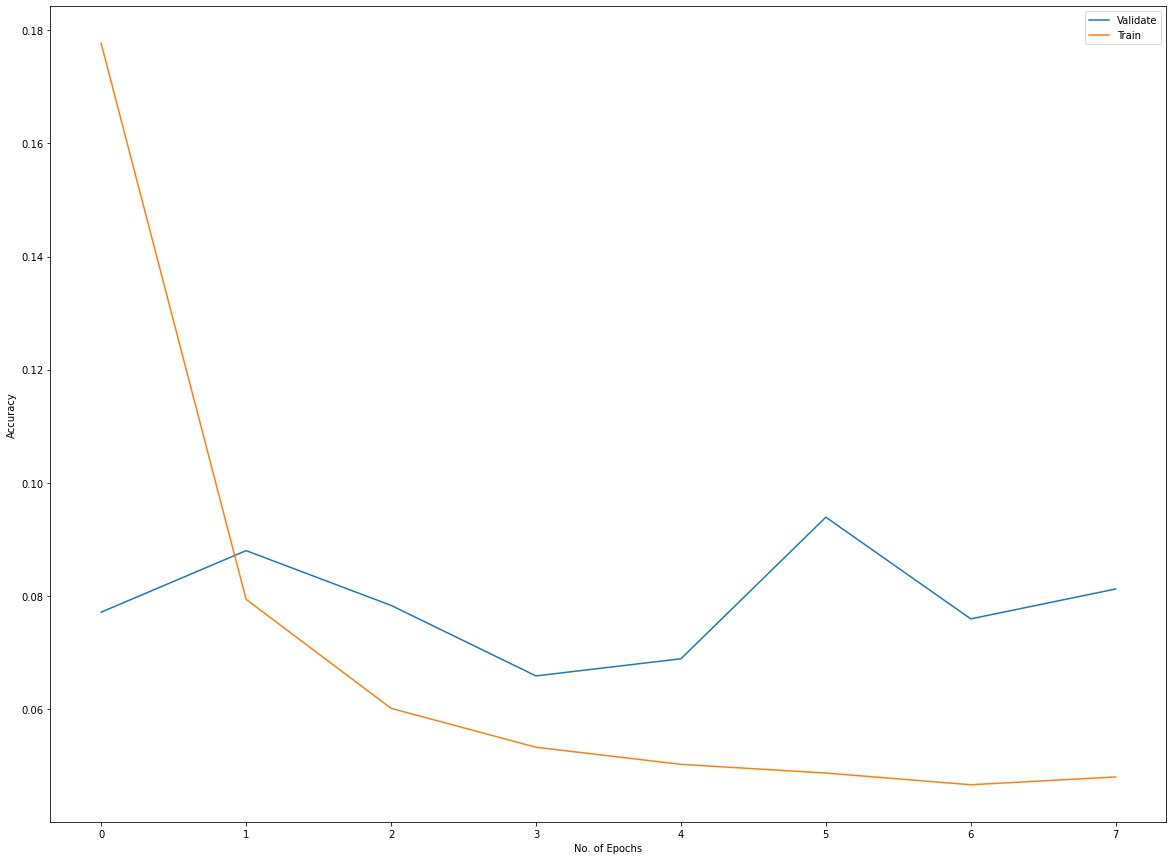

In [ ]:
print("The curves for losses of training data and validation data are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_loss,label="Validate")
plt.plot(avg_training_loss,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### NOTE: **For all the plots in this file and other files, the epoch numbers start from 1. The X-axis shows that epochs start from 0 because a list of values is passed for plotting the values. This is because indexing in a list starts from 0 and not 1**

In the above plot for loss curves, we implemented early stopping in our training. We checked for increase in validation loss and stop when the validation loss increases beyond a fixed limit which in our case is the patience factor. For training this dataset, we set the patience factor as 4. So once the validation loss increases for 4 continous epochs, we immediately stop training our model and we save the model at the epoch before which there was continous increase in validation loss. In this case early stopping takes place at epoch 7.

The curves for accuracy of training data and validation data are :


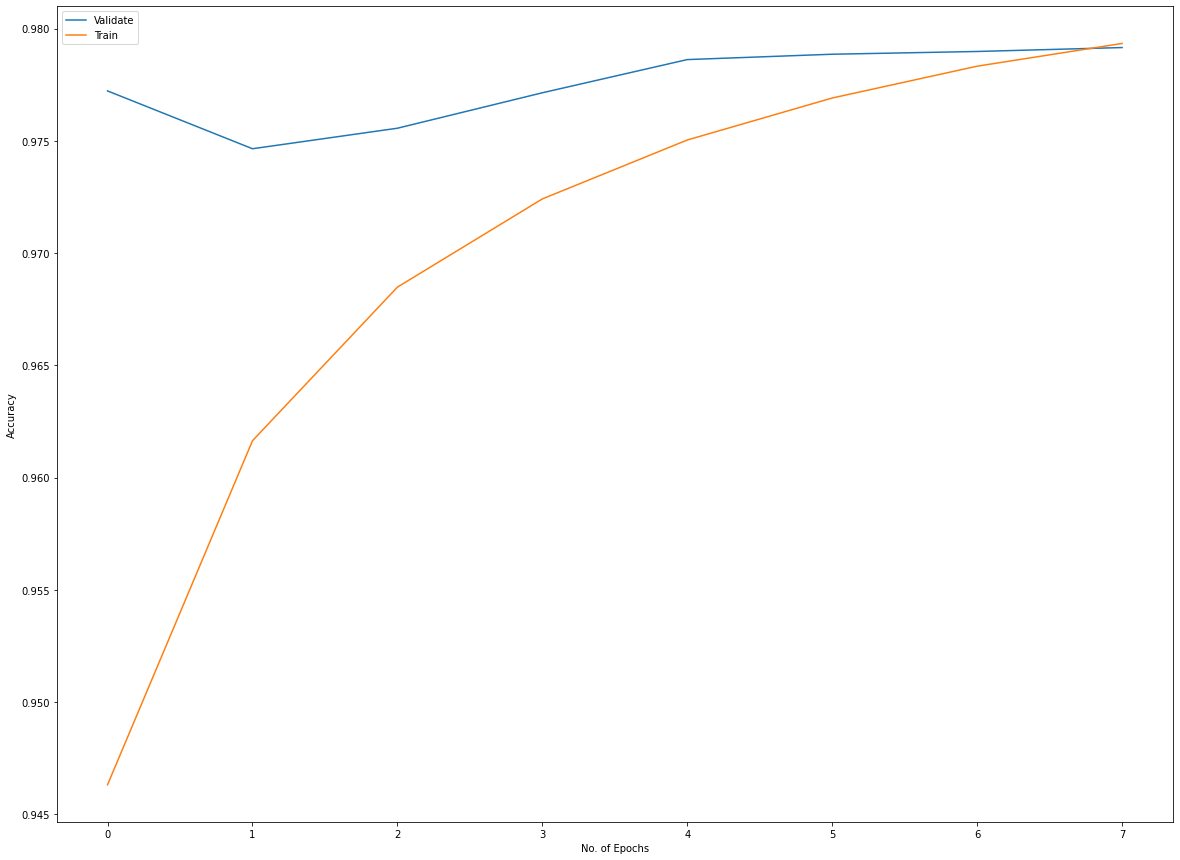

In [ ]:
print("The curves for accuracy of training data and validation data are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_accuracy,label="Validate")
plt.plot(avg_training_accuracy,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In the above plot for accuracy curves, we see how the accuracy increases as the number of epochs increase. Here, initially after one epoch, the validation accuracy drops minutely and then it rises and comes to a point that it becomes steady

In [ ]:
print("Testing CNN Model:")
model.eval()
test_accuracy = 0
batch_test_accuracy = []
#avg_testing_accuracy = []
test_confusion_matrix = torch.zeros(10,  10)
for i , (x,y) in enumerate(test_loader):
    images3 = Variable(x)
    labels3 = Variable(y)
    
    output3 = model(images3)
    _, preds = torch.max(output3, 1)
    for t, p in zip(labels3.view(-1), preds.view(-1)):
                test_confusion_matrix[t.long(), p.long()] += 1
    #predictions = torch.cat((predictions,output3),dim=0)
    test_prediction = (torch.max(output3.data, dim=1)[1] == labels3.data)
        
    batch_test_accuracy.append(test_prediction.float().mean().item())
    
avg_test_accuracy = np.mean(batch_test_accuracy)

#print(batch_test_accuracy)
print("\nThe accuracy after testing the CNN model is :",avg_test_accuracy)
print("\nThe confusion matrix for test dataset is :")

class_names = ["0","1","2","3","4","5","6","7","8","9"]
test_confusion_matrix = pd.DataFrame(data=test_confusion_matrix,index=class_names,columns=class_names).astype(int)
print(test_confusion_matrix)

Testing CNN Model:

The accuracy after testing the CNN model is : 0.9850239616613419

The confusion matrix for test dataset is :
     0     1     2    3    4    5    6     7    8    9
0  977     0     0    0    0    0    2     0    0    1
1    0  1124     1    2    0    0    0     1    7    0
2    4     2  1014    2    1    0    0     4    4    1
3    0     1     2  994    0    8    0     2    1    2
4    1     0     0    1  956    0    0     1    3   20
5    0     0     1    1    0  883    4     0    3    0
6    5     4     2    0    5    1  938     0    2    1
7    0     4     4    1    0    1    0  1012    2    4
8    1     0     3    2    0    2    0     2  963    1
9    0     0     1    1    5    6    0     4    3  989


For the model, we have used two hidden layers and applied Xavier-Glorot initialization for initializing the weights. We initialized our learning rate at 0.05 and increase it by 10% after every 10 epochs. We first split the MNIST dataset into training set, validation set and testing set. The validation data is itself again kept aside from the training data. It consists of 10% of training data.
From the graph, we see that accuracy increases when the model is trained for more epochs and thus the graph fits reasonably well.
Using the saved best model after early stopping, we get an accuracy of 98% on our testing data. 




### References Used for this assignment:
1. https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9

2. https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook

3. https://clay-atlas.com/us/blog/2021/08/25/pytorch-en-early-stopping/

4. https://www.kaggle.com/code/akhileshrai/tutorial-early-stopping-vanilla-rnn-pytorch/notebook

5. https://towardsdatascience.com/build-a-fashion-mnist-cnn-pytorch-style-efb297e22582

6. https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial

